<a href="https://colab.research.google.com/github/nargonne/gravitational-lens-hunter/blob/main/Gravity_Lens_Hunter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational Lens Classification

Project by D. Harrison, 2023

<br />

### Version 1

* **Baseline:** [CNN Model-8, Galaxy Morphology Classifier](https://github.com/nargonne/Galaxy-Morphology-Classification)
* **Data:** Simulated images of gravitational lenses
* **Dataset Size:** 32389 simulated images at 224x224 px.
* **Image Preprocessing:** See below for details


<br />

---

<br />

This project employs a Convolutional Neural Network (CNN), originally developed for galaxy morphology classification, to serve as a baseline model for identifying gravitational lenses.

Before we can begin training, we need to obtain a dataset of gravitational lenses. This task presents significant challenges as actual gravitational lenses are scarce. In addition to being few in number, the available lenses come from disparate catalogs and surveys, varying widely in quality and resolution. Compounding the issue, most of the labeled images are embedded within extensive catalogs, such as the Sloan Digital Sky Survey (SDSS). Consequently, we have yet to discover a clean dataset of images suitable for training. This problem is exacerbated by the shortage of high-quality, labeled images in the first place.

To overcome these obstacles, we have decided to generate simulated gravitational lens images using the `deeplenstronomy` package. The overall approach is as follows:

**Generate Simulated Images:** Utilize the `deeplenstronomy` package to create a synthetic dataset that can mimic the properties of gravitational lenses and prepare them like so:

* Manually scan through and delete any that look problematic. Such as they look too much like a lenticular galaxy or just a point source. How? squint at the images while you scroll through them quickly. If anything looks wierd then it problably is. I know this is silly but it kind of works on smaller datasets.
* Convert: `mogrify -format jpg -path . *.png && rm *.png`
* Grayscale: `mogrify -colorspace Gray *.jpg`
* Resize: `find ./ -name "*.jpg" -type f -exec mogrify -resize 224x224 {} +`
* Tarball: `COPYFILE_DISABLE=true tar --exclude='.DS_Store' -cf ../glsim-images-224x224.tar ./*`
* Compress: `gzip -9 glsim-images-224x224.tar`

This approach allows us to create a controlled training environment, addressing the scarcity and inconsistency of existing gravitational lens data.


**Modify and Train Model:** Apply the Model-8 architecture, making minor adjustments to transform it from a multi-classifier to a binary classifier model, suitable for identifying gravitational lenses.

**Test the Model:** Scan through the [Galaxy Zoo 2 dataset](https://data.galaxyzoo.org/) to extract a set of candidate images that may be gravitational lenses. A careful examination will then be conducted to confirm whether they have been correctly identified.


<br />

**References:**

* [deeplenstronomy](https://doi.org/10.21105/joss.02854)

* [lenstronomy](http://www.sciencedirect.com/science/article/pii/S2212686418301869)

* [Galaxy Zoo dataset](https://data.galaxyzoo.org/)

## Setup Workspace

1. Import libraries and such
1. Create the directories and path variables used in this notebook
1. Copy over the source data files and unpack them

First, We need to mount Google Drive as that is where the galaxy images are stored.

After that, make a function that'll be called to create folders here in Colab.

In [ ]:
# Before any plotting or import of matplotlib is performed
# you must execute the %matplotlib magic command.
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Import common modules
import os
import shutil
import tarfile, zipfile
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# Less common but needed for this notebook
from google.colab import drive    # Need this to mount your Google drive
from google.colab import files
from shutil import copy           # Need this for coping files
from pathlib import Path          # For file paths
from math import ceil             # For rounding numbers to nearest int
from PIL import Image             # Working with images like opening them
from tqdm.notebook import tqdm    # A neat little progress bar
from google.colab import files    # Working with colab dirs
from numpy import expand_dims     # See the Featuremaps block
from IPython import display       # Display local file img in code cell
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight # Try to balance the training classes
from sklearn.metrics import classification_report
import random                     # It is random

# TensorFlow stuff
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model


# Check to see what runtime you are using
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Check memory usage
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Aug 21 12:49:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mount Google Drive
if os.path.isdir('/content/gdrive') != True:
  drive.mount('/content/gdrive')
else:
  print(f"Google Drive is already mounted.")

Mounted at /content/gdrive


In [ ]:
# Function to create a directory
def make_dir(path):
  """
  A simple function check if a directory already
  exists and create one as needed.
  """
  if os.path.isdir(path) != True:
    try:
      os.makedirs(path)
    except OSError:
      print (f"Failed to create the directory {path}")
    else:
      print (f"Successfully created the directory {path}")
  else:
    print(f"The {path} Directory already exists.")

Create local directories here in the Colaboratory file system for the source images, data, and such.

Also, make a directory for the log files.

In [ ]:
Project_Folder = "/content/gdrive/MyDrive/Colab Notebooks/Gravity_Lens_Hunter"

Project_Data = '/content/gdrive/MyDrive/Colab Notebooks/Gravity_Lens_Hunter/Data'

# The base data directory here in the Colab VM
train_dir = '/content/dataset'
make_dir(train_dir)

# Directory where the lens images are stored
lens_dir = '/content/dataset/lenses'
make_dir(lens_dir)

# Directory where the NOT-lens images are stored
not_lens_dir = '/content/dataset/not_lenses'
make_dir(not_lens_dir)

# Make the log directory
make_dir("/tmp/logs")

# Path for Tensorboard logs
log_dir = "/tmp/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Successfully created the directory /content/dataset
Successfully created the directory /content/dataset/lenses
Successfully created the directory /content/dataset/not_lenses
Successfully created the directory /tmp/logs


Now copy over the zipped original images from Google Drive and unpack them into the Colab directories we just created. We are doing it this way for two main reasons:

1. We don't want to keep thousands of files on our Google Drive
2. It's faster to process files locally in Colab

In [ ]:
## TRAINING SET FOR LENSES

# The training images source file path
source_tarball = os.path.join(Project_Data, 'simlens-images-224x224.tar.gz')

file = tarfile.open(source_tarball)

# extracting file into the training directory
file.extractall(lens_dir)

file.close()

In [ ]:
## TRAINING SET FOR NOT-LENSES

# The training images source file path
source_tarball = os.path.join(Project_Data, 'not_lens-images-224x224.tar.gz')

file = tarfile.open(source_tarball)

# extracting file into the training directory
file.extractall(not_lens_dir)

file.close()

### Have a Look

Now that we have created local directories and copied over the training images, lets take a look a some random samples to see what we have.

Total number of training images: 32389

The image size is (224, 224)



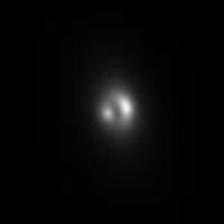

In [ ]:
# Get the list of all files in the training directory
image_files = [f for f in os.listdir(lens_dir) if os.path.isfile(os.path.join(lens_dir, f))]

# Choose a random file from the list
random_image_filename = random.choice(image_files)

# Create the full path to the random file
sample_image_path = os.path.join(lens_dir, random_image_filename)

# Open the image and check its dimensions
sample_image = Image.open(sample_image_path)

# Display the image info
total_training = len(os.listdir(lens_dir)) + len(os.listdir(not_lens_dir))
print(f"Total number of training images: {total_training}\n")
print(f"The image size is {sample_image.size}\n")

sample_image

## Functions to Visualize the Images

---

These are functions for getting a random set of images and display them in a nice grid format.

In [ ]:
# Function: Display a set of images
def show_images(images):
  """
  This function takes a list of images and displays them in
  a single column; Recommend using about 5
  """
  # Why the below neg of the neg floor division?
  # Python // returns the result rounded down and we need it
  # rounded UP. So reverse the divison and get what's needed.
  rows = -(-len(images) // 5)
  columns = 5

  # create figure
  fig = plt.figure(figsize=(columns * 2, rows * 3))

  for i, img in enumerate(images):
    image = mpimg.imread(img)

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{os.path.basename(img)}")
    plt.tight_layout()


# Function: Select random images into a list
def get_random_images(num_samples, directory):
  """
  This function grabs a list of random images (file names) then pops the
  corresponding images into thier own lists.
  """
  random_images = []

  for i in range(num_samples):
    fname = np.random.choice(os.listdir(directory))
    fpath = os.path.join(directory, fname)
    random_images.append(fpath)

  return random_images

## View Some of the Images

Visual examination of images randomly selected from the training directory.

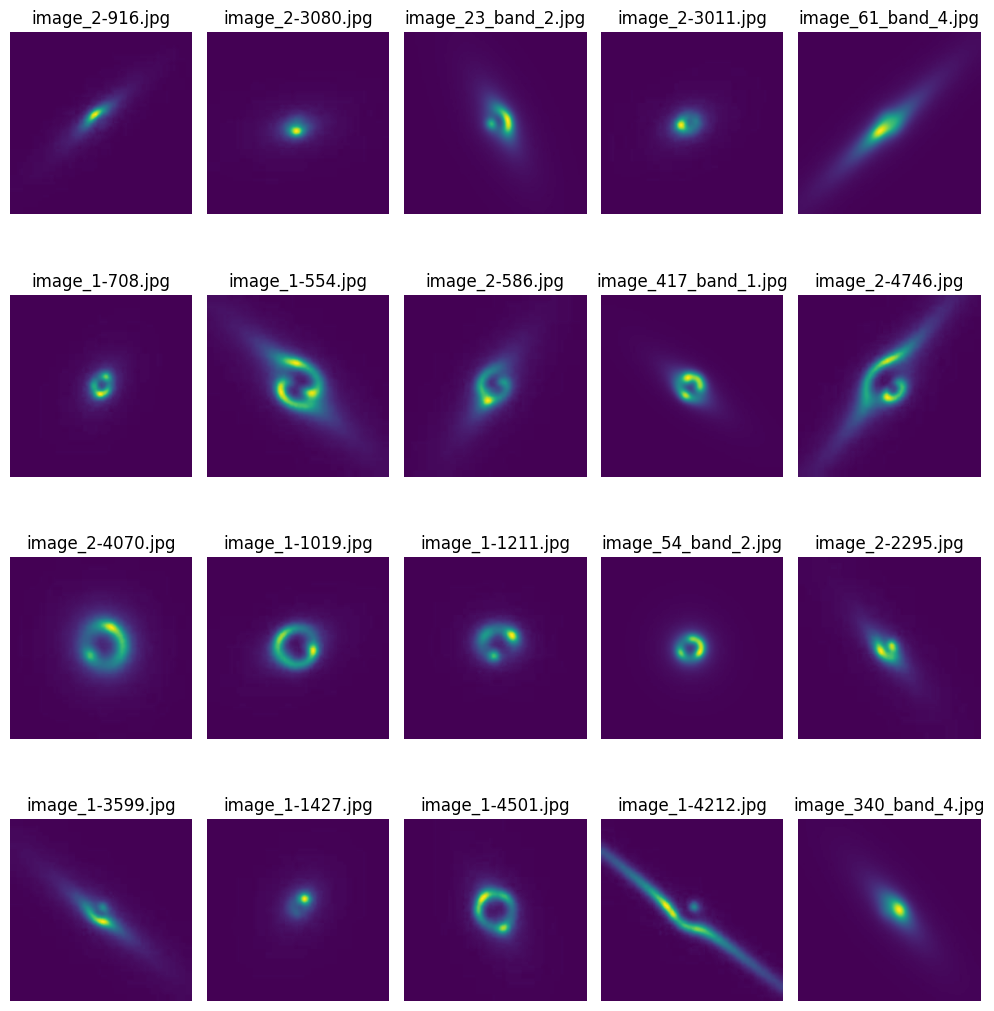

In [ ]:
rnd_images = get_random_images(20, lens_dir)
show_images(rnd_images)

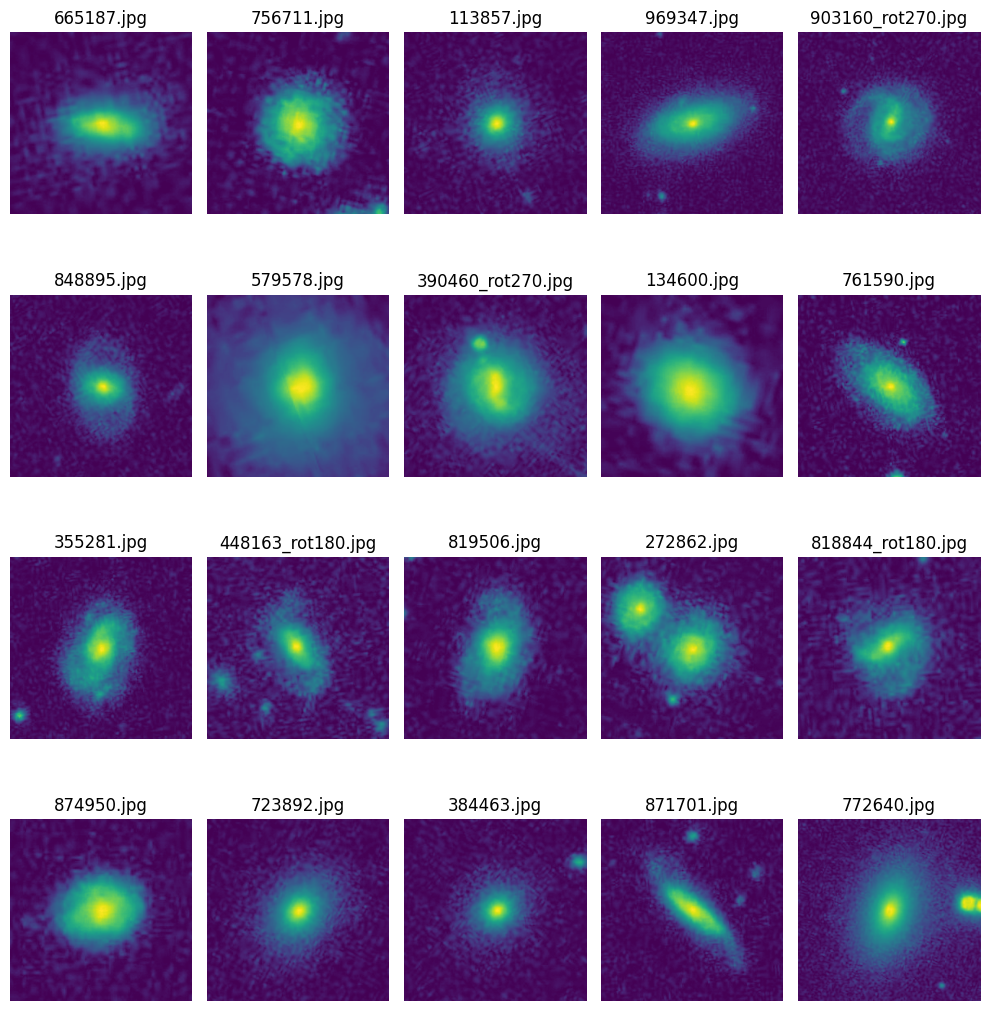

In [ ]:
rnd_images = get_random_images(20, not_lens_dir)
show_images(rnd_images)

## Image processing and augmentations

**Remember!** The folder names ***act as the labels*** for the training phase.

<br >

Data augmenttation introduces variations to the training data, enabling the model to learn from diverse perspectives. These transformations help improve the model's ability to generalize to unseen examples and reduce overfitting.

Some things to do with the images:

*   Scale the images down to see if it helps speed things up without loosing accuracy.
*   Rescale them to some size appropriate such as what's needed by a a pre-trained model like VGG or whatever.
*   Try various agumentations like flips and rotations.
*   Extend the dataset using augmentations for more training examples.
*   RGB to Grayscale -- see how goes without color.
*   Mask out all but the central image. Perhaps decluttering the image and focus only on the central part will give good results.

<br />

---

### Choosing a batch size ###

A larger batch size, such as 100, offers certain advantages. It tends to provide smoother gradient updates since it incorporates a more diverse representation of the dataset during each update step. With a larger batch size, the model can converge faster as it benefits by processing a larger number of samples simultaneously. Additionally, larger batch sizes can take advantage of parallel processing thus improved training speed.

However, there are potential drawbacks to using larger batch sizes. Primarily this is down to memory and computing resourses needed. Moreover, using larger batch sizes might make the model less prone to generalizing well to unseen data, potentially resulting in overfitting so we tried a few different sizes and settled on 100 as a good choice.

We have subscribed to Colab Pro to gain access to higher memory and faster compute resource in hopes of mitigating these bottlenecks.

<br >

---

### ImageDataGenerator ###

Read all about it here: [Keras ImageDataGenerator and Data Augmentation](https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

And explore the TensorFlow functions here: [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

<br />

Here are some of our initial choices used:

- `rescale=1.0/255.0`: Rescales the pixel values of the images to a range between 0 and 1 by dividing them by 255. This normalization is a common preprocessing step.

- `rotation_range=20`: Specifies the range (in degrees) for randomly rotating the images. While it may not be particularly helpful for galaxy images, it does not hinder the process.

- `horizontal_flip=True`: Enables random horizontal flipping of the images during data augmentation. Each image has a 50% chance of being flipped horizontally, which can help improve the model's ability to handle horizontally oriented objects, although this may not be very useful with galaxy images.

- `validation_split=0.2`: Splits the data into training and validation sets. This parameter specifies the fraction of the data to be allocated for validation. In this case, 20% of the data will be reserved for validation, and the remaining 80% will be used for training.

In [ ]:
# Batch size refers to the number of samples in each training iteration
batch_size = 100

# The target size is simply the image (width, height)
#target_size = sample_image.size
target_size = (224,224)
print(f"Target size is {target_size}\n")

# Set the color_mode parameter to "rgb" or "grayscale"
color_mode = "grayscale"


Target size is (224, 224)



In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest',
    validation_split=0.2    # Set validation split size
)

# Flow from the training directory
print("\nTraining split:")
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=target_size,
    color_mode=color_mode,
    classes=None,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset='training', # Set this as training data
    interpolation="nearest",)

print("\nValidation split:")
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data because using keras to split
    target_size=target_size,
    color_mode=color_mode,
    classes=None,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset='validation', # Set this as validation data
    interpolation="nearest",)

# Sanity check: Split and dataset size equivilant
print(f"\nSplits total and total dataset size: {train_generator.n + validation_generator.n} == {total_training}")
assert train_generator.n + validation_generator.n == total_training, \
  f"\nThe splits should be equal to the total dataset size but something went wrong."
clear_session()

## CNN Model Architectures

In this step, the layers of the CNN are defined. Typically, a CNN includes a combination of convolutional layers, pooling layers, and fully connected layers, and finally the output.

This is a very basic model which is an amalgumation of ideas learned from online tutorials, books, and a lot of trail and error. ([TensorFlow Tutorials](https://www.tensorflow.org/tutorials), [Hands on Machine Learning..](978-1098125974), [Coursera Courses](Coursera.org) )

In [ ]:
# Function: Define the CNN model (Version 8)
def get_cnn_model(input_shape):
    """
    This function builds a sequential CNN and returns the model object.
    In this version, I've tweaked the filters, add layers to progressivly
    increase, and lowered the dropout.
    """
    model = tf.keras.models.Sequential([

    tf.keras.layers.Input(shape=(input_shape)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')

])


    return model

## Get the model and check it out

In this code block, we verify that the input shape is suitable and display the model summary to ensure it matches our expectations.

For this project, we are working with images that have been cropped and resized to dimensions of 224x224 pixels. This choice was made because these images are large enough to retain the original resolution of the central object, while also being centrally cropped to reduce their overall size thus improving compute performance.

In [ ]:
# Set the color channel based on previous choice
if (color_mode == "grayscale"):
  channel_num = 1
else:
  channel_num = 3

# The input shape is the target_size plus the color channel: 1 or 3
input_shape = target_size + (channel_num,)
print(f"The input shape is {input_shape}\n")

# Sanity check: image size
assert input_shape == (224, 224, 1), \
  f"Expected shape (224, 224, 1) and got {input_shape}"
clear_session()

# Get model
model = get_cnn_model(input_shape)

model.summary()

The input shape is (224, 224, 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1

In [ ]:
# Load the saved weights
#weights_path = os.path.join(Project_Folder, '16Aug-overfitted.h5')
#model.load_weights(weights_path)

## Look at Activation Map(s)

In the first convolutional layer, multiple versions of the image emerge, each emphasizing different features.

The filters in this layer are designed to detect specific patterns like edges, corners, or textures. As these filters convolve across the image, they generate activation maps (aka feature maps) that highlight regions with these patterns.

By stacking up multiple convolutional layers, the network learns hierarchical representations, capturing more complex features along the way.


1/1 [==============================] - 7s 7s/step


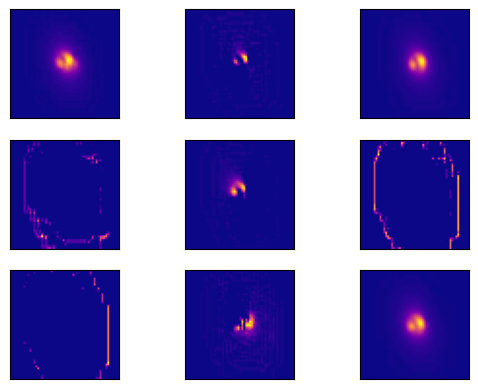

In [ ]:
# Visualize the feature maps for one of the images
# credit: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks
#

# redefine model to output right after the first hidden layer
model2 = Model(inputs=model.inputs, outputs=model.layers[10].output)
#model2.summary()

if (color_mode == "rgb"):
  # load the image with the required shape for RGB image
  img = load_img(sample_image_path, target_size=(224, 224))
elif (color_mode == "grayscale"):
  # Load the image with the required shape for B&W image=
  img = Image.open(sample_image_path).convert('L')

# convert the image to an array
img = img_to_array(img)

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# get feature map for first hidden layer
feature_maps = model2.predict(img)

# plot 8x8 squares
square = 3
ix = 1
for _ in range(square):
  for _ in range(square):
    # specify subplot and turn of axis
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])

    # plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='plasma')
    ix += 1

# show the figure
plt.show()

## Callbacks

**Early stopping:** monitors the performance on the validation data (`val_loss`) during training and stops training early if the performance stops improving. The ***patience parameter*** refers to the number of epochs that the training process should continue without any improvement in the validation loss before stopping the training process.

**Tensorboard** is a TensorFlow dashboard that is super helpful.

> TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more. See [Getting Started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started#:~:text=TensorBoard%20is%20a%20tool%20for,dimensional%20space%2C%20and%20much%20more.)  AND [Using TensorBoard in Notebooks](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           verbose=0,
                           mode='auto',
                           restore_best_weights=True)

# Tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Save the weights from best
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(Project_Folder, 'model_checkpoint.h5'),
    save_weights_only=True,
    save_best_only=True)

## Compile and Fit model

**Compile** refers to configuring the model for training by specifying the optimizer, loss function, and evaluation metric.

*   Loss function: Use [Binary Cross-Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) because this is an "Yes/No" (binary) kind of problem.
*   Optimizer: Use Adam with a learning rate scheduler. See [A Complete Guide to Adam and RMSprop Optimizer](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)

* Metrics: Using accuracy because it makes sense.

**Fit** refers to training the model on the training data by iterating over the data in batches and updating the model parameters based on the gradients computed during training. See [Stochastic Gradient Decent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).


In [ ]:
# Try out a learning rate schedulder for Adam
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Putting it together
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Calculate steps per epoch and validaton steps
# Common formula is train_length // batch_size (Why? See Hands on ML..)
epoch_steps = round(train_generator.n / batch_size)
val_steps   = round(validation_generator.n / batch_size)

# Fitting or learning part
history = model.fit(train_generator,
                    epochs=25,
                    steps_per_epoch=epoch_steps,
                    validation_data=validation_generator,
                    verbose=1,
                    validation_steps=val_steps,
                    callbacks=[early_stop, tensorboard_callback, save_best],
                    )


Epoch 1/25
259/259 [==============================] - 166s 599ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 5.5880 - val_accuracy: 0.4094
Epoch 2/25
259/259 [==============================] - 161s 621ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.4549 - val_accuracy: 0.5589
Epoch 3/25
259/259 [==============================] - 153s 590ms/step - loss: 9.4164e-04 - accuracy: 0.9998 - val_loss: 3.5803e-04 - val_accuracy: 1.0000
Epoch 4/25
259/259 [==============================] - 168s 650ms/step - loss: 7.0674e-04 - accuracy: 0.9998 - val_loss: 1.2948e-04 - val_accuracy: 1.0000
Epoch 5/25
259/259 [==============================] - 169s 651ms/step - loss: 6.1476e-04 - accuracy: 0.9998 - val_loss: 0.9701 - val_accuracy: 0.6722
Epoch 6/25
259/259 [==============================] - 153s 592ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.4158 - val_accuracy: 0.8209
Epoch 7/25
259/259 [==============================] - 171s 662ms/step - loss: 5.0513e-04 - accuracy: 0.9

## Analysis

In [ ]:
# Stuff to add to the plot titles
current_time = datetime.datetime.now().strftime("%d%b%Y %H:%M")
title_extra = "GLHunter Run-1"

Best validation accuracy is 100.00%
Best validation loss is 0.0000
---------------------------------



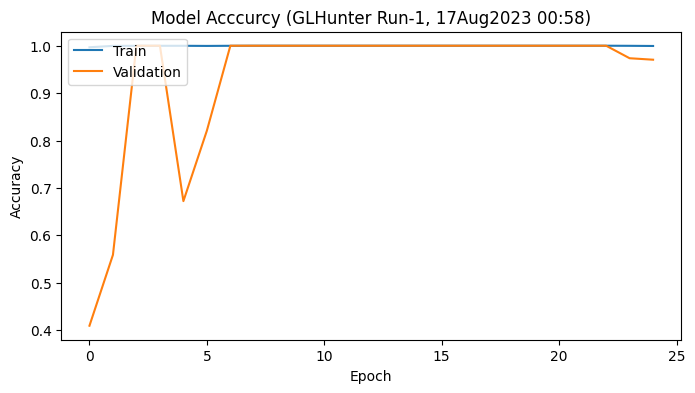

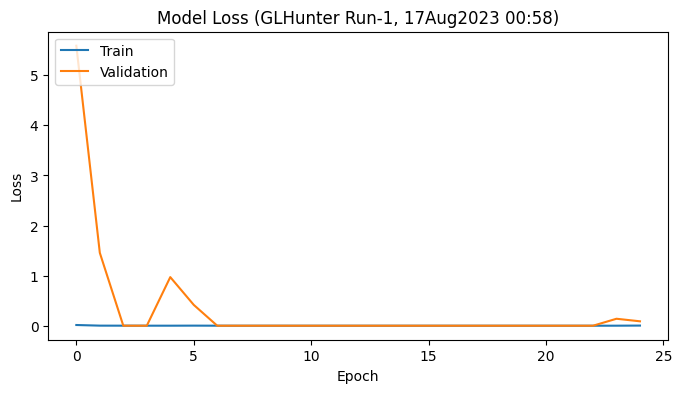

In [ ]:
# Get the maximum validation accuracy and minimum validation loss
max_val_acc = np.max(history.history['val_accuracy'])
min_val_loss = np.min(history.history['val_loss'])

print(f"Best validation accuracy is {max_val_acc * 100:.2f}%")
print(f"Best validation loss is {min_val_loss:.4f}")
print("---------------------------------\n")

# Plot training & validation accuracy values
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f"Model Acccurcy ({title_extra}, {current_time})")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"Model Loss ({title_extra}, {current_time})")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Call the TensorFlow dashboard
%tensorboard --logdir {log_dir}

## Test

Upload samples and let the model make predictions.

1/1 [==============================] - 0s 18ms/step


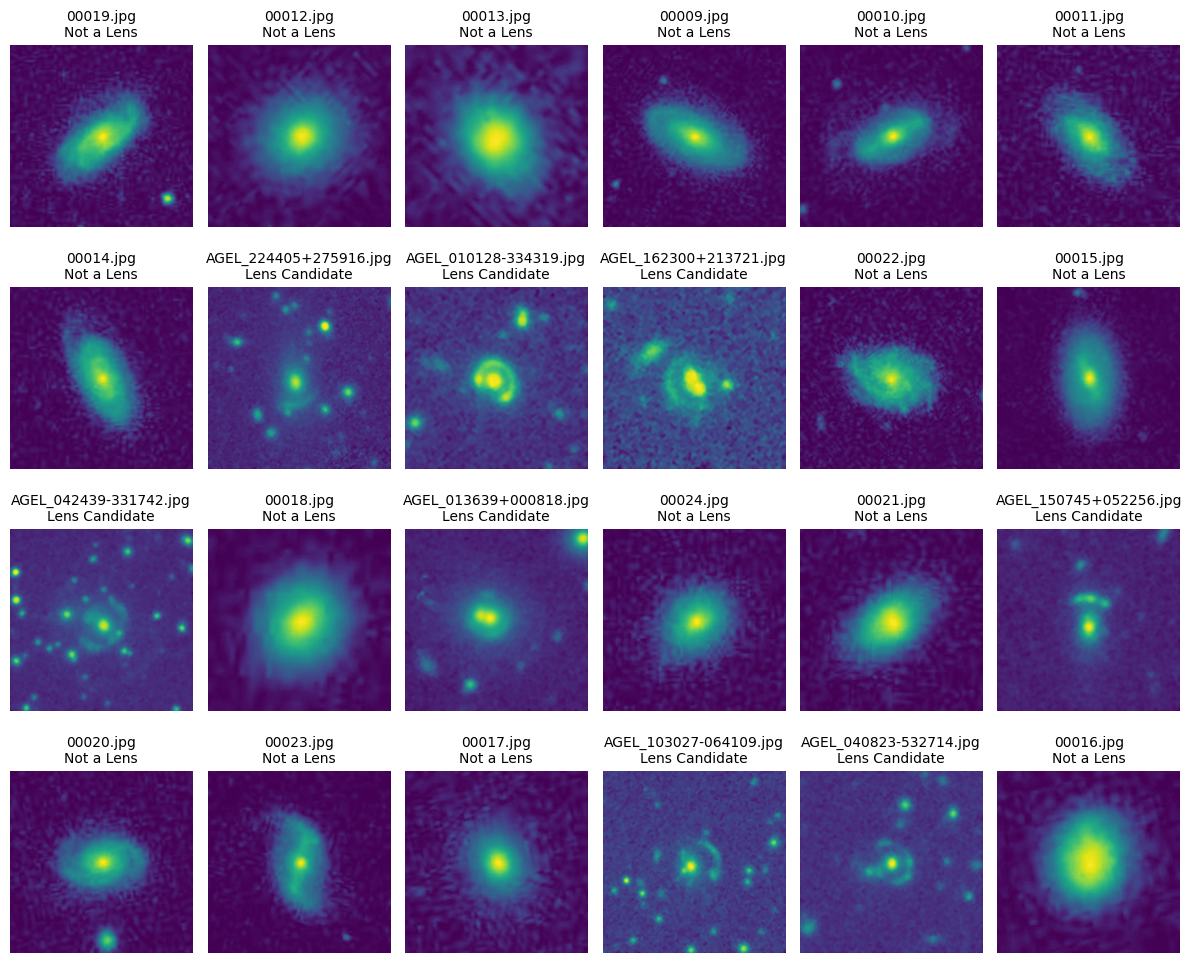

In [ ]:
# Define labels
# Double check the order is correct and if see the
# predictions are way off then check this first.
labels = {0:'Lens Candidate', 1:'Not a Lens'}

# Set the target size
target_size = target_size

# Define where the images are
image_dir = '/content/gz-test-images_3'

# Get list of image files
all_files = os.listdir(image_dir)
image_files = [fn for fn in all_files if fn.lower().endswith('.jpg')]

# Load a Saved Model
savedModelPath = os.path.join(Project_Folder, '16Aug-overfitted.h5')

# The model is loaded within this notebook in section "Get the model..."
#model = load_model(savedModelPath)

# Number of images
n = len(image_files)

# If the number of images is not exactly 24, this code might fail
# So it's better to assert this condition.
# Todo: fix this requirement
assert n == 24, f"Expected 24 images, but got {n} images."

# Create a subplot
fig, axs = plt.subplots(4, 6, figsize=(12, 10))

# Flatten the axis array, to make indexing easier
axs = axs.flatten()

# Loop through the images, make predeictions, and add to the plot
for idx, fn in enumerate(image_files):
    # Predicting images
    path = os.path.join(image_dir, fn)
    img = image.load_img(path, target_size=target_size, color_mode='grayscale')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Apply any required preprocessing
    x = x / 255.0

    prob = model.predict(x, batch_size=3)
    label_index = int(prob[0] > 0.5) # Assuming a threshold of 0.5

    axs[idx].imshow(img)
    axs[idx].axis('Off')
    axs[idx].set_title(f'{fn}\n{labels[label_index]}', fontsize=10)

plt.tight_layout()
plt.show()